In [1]:
#remotes::install_github("coolbutuseless/ggpattern")
list.of.packages <- c("ggpubr","magick","ggpattern","tidyverse","stargazer","dplyr","ggplot2")
new.packages <- list.of.packages[!(list.of.packages %in% installed.packages()[,"Package"])]
if(length(new.packages)) install.packages(new.packages, repos = "http://cran.us.r-project.org")

invisible(lapply(list.of.packages, library, character.only = TRUE))

select <- dplyr::select

options(repr.matrix.max.rows=50, repr.matrix.max.cols=500)  

Loading required package: ggplot2

Loading required package: magrittr

Linking to ImageMagick 6.8.9.9
Enabled features: cairo, fontconfig, freetype, fftw, lcms, pango, rsvg, x11
Disabled features: ghostscript, webp

Using 8 threads


Attaching package: ‘ggpattern’


The following objects are masked from ‘package:ggplot2’:

    flip_data, flipped_names, gg_dep, has_flipped_aes, remove_missing,
    should_stop, waiver


── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ tibble  3.1.0     ✔ dplyr   0.8.4
✔ tidyr   1.0.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0
✔ purrr   0.3.3     

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ tidyr::extract()             masks magrittr::extract()
✖ dplyr::filter()              masks stats::filter()
✖ ggpattern::has_flipped_aes() masks ggplot2::has_flipped_aes()
✖ dplyr::lag()                 masks stats::lag()
✖ purrr::set_names()           masks magrittr::set_names()




### Database one row each paper

In [2]:
path <- "../5_Final_databases/output/database_one_row_each_paper.csv"
df <- read_csv(path)
sprintf("%i x %i dataframe", nrow(df), ncol(df))
head(df,1)

Parsed with column specification:
cols(
  .default = col_double(),
  ISO_3 = col_character(),
  Country = col_character(),
  Region = col_character(),
  title = col_character(),
  authors = col_character(),
  source = col_character(),
  doi = col_character(),
  abstract = col_character(),
  author_keywords = col_character(),
  model = col_character(),
  scopus_number = col_character(),
  WOS_number = col_character()
)

See spec(...) for full column specifications.



[1] "4691 x 53 dataframe"

ISO_3,Country,Region,title,authors,source,doi,abstract,author_keywords,publication_year,horizon_year,model,scopus_number,WOS_number,Energy efficiency,Climate change,Power,Vehicle,Cement,Forest,Steel/Iron,Buildings,Water,Air Pollution,Electricity,CCS,Transport,Policy-Dvlpt-Eco,Agriculture,Tax,Heat Pump,Consumption,Scenario,Wind/Solar,Costs,Coal,Nuclear,Fuel,Renewable Energies,Flood Risk,Technology,Bioenergy,Urban,Hydrogen,Permit market,Drought,Crop yield,Peak,Oil,Land Use,Target/INDC,Waste,System
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
AFG,Afghanistan,Asia,The renewable energy sector in Afghanistan: Policy and potential,"Fahimi, A; Upham, P",WILEY INTERDISCIPLINARY REVIEWS-ENERGY AND ENVIRONMENT,10.1002/wene.280,"Afghanistan has one of the lowest rates of access to and usage of electricity in the world. Fuelwood, charcoal, agricultural, and animal waste still dominate in meeting energy needs for cooking and heating, with a large percentage of the population using kerosene, candles, and gas for lighting. Yet the situation has changed significantly since the U.S. and coalition combat operations that began at the end of 2001. The period through to the present day has seen a fivefold increase in the electrification rate; agreements with Central Asian countries and Iran for importing electricity; the implementation of thousands of small-scale renewable energy projects in rural areas; the development and rehabilitation of several large-scale energy projects; the (partial) development of the institutional, policy, and regulatory landscape; and the expansion of transmission lines and distribution networks. Although accurate information is scarce, Afghanistan has both substantial fossil fuel reserves and renewable energy potential. The country's wind power potential alone looks likely to exceed projected power demand for several decades ahead. Similarly, both the estimated hydropower and solar photovoltaic (PV) potential each exceed projected 2032 power demand. The institutional context of the Afghanistan energy sector is complex, comprising multiple ministries, government agencies, aid agencies, and intergovernmental organizations. Nonetheless, given suitable coordination, the technologies, natural resources, and capabilities are available for transforming the sector and the lives of many people. This article is categorized under: Energy Infrastructure > Climate and Environment Energy Policy and Planning > Economics and Policy Energy Policy and Planning > Systems and Infrastructure",NA,2018,2032,NA,NA,WOS:000425432900006,1,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### Publication year distribution 

In [3]:
df_pub <- df %>% 
            select(publication_year,horizon_year)%>%
            #for easier reading aggregate all pub year before 2000 to 2000
            mutate(pub_year = ifelse(publication_year <= 2002, 2002, publication_year),
                   hor_year = ifelse(horizon_year <= 2030, "[2025;2030]", 
                                     ifelse(horizon_year > 2050, "(2050;2100]", "(2030;2050]")))%>% 
            #calculate the sum of publi by region
            group_by(pub_year,hor_year) %>% 
            summarise('number'=n()) %>% 
            ungroup() %>% 
            #calculate percentage for column labels
            mutate('relative'=unlist(by(data = number, INDICES = pub_year, 
                              FUN = function(x) round(x/sum(x)*100, digits = 0)))) %>% 
            mutate(Estimated = ifelse(pub_year == 2002, "aggregated", "yearly"))

In [4]:
plot_pub <- ggplot(data = df_pub,aes(x=pub_year,y=number,fill=hor_year, pattern = Estimated)) + 
           ggtitle('a) Horizon year per publication year')+
           geom_bar_pattern(stat="identity",
                           color = "black", 
                           pattern_fill = "black",
                           pattern_angle = 45,
                           pattern_density = 0.1,
                           pattern_spacing = 0.02,
                           pattern_key_scale_factor = 0.2) +
          scale_pattern_manual(values = c(aggregated = "stripe", yearly = "none")) +
          labs(x = " \n Publication Year", y = "Number of Papers \n ", fill = "Horizon Year",
               pattern = "Level"
              ) + 
          guides(pattern = FALSE, fill = guide_legend(override.aes = list(pattern = "none")))+ 
          geom_vline(xintercept= 2002.5, linetype="dashed", size=0.5)+
          annotate("text", x = 2002, y = 200, label = "Until 2002",angle = 90) +
          xlab(" \n Publication Year")+
          ylab("Number of Papers \n ")+
          geom_text(data = subset(df_pub,pub_year ==2002 & relative >=15),
                    aes(x = pub_year, label = paste0(relative,'%')),
                    colour = 'black', position=position_stack(vjust=0.5))+
          geom_text(data = subset(df_pub,pub_year >=2007 & pub_year <=2013 & relative >=15),
                    aes(x = pub_year, label = paste0(relative,'%')),
                    colour = 'black', position=position_stack(vjust=0.5))+
          geom_text(data = subset(df_pub,pub_year >=2014 & pub_year <=2016 & relative >=5),
                    aes(x = pub_year, label = paste0(relative,'%')),
                    colour = 'black', position=position_stack(vjust=0.5))+
          geom_text(data = subset(df_pub,pub_year >=2017 & pub_year <=2020 & relative >=2),
                    aes(x = pub_year, label = paste0(relative,'%')),
                    colour = 'black', position=position_stack(vjust=0.5))+
          theme_minimal()+
          theme(
            plot.title = element_text(size = rel(2)),
            legend.title = element_text(size = 16,face ="bold"),
            legend.text = element_text(size = 16),
            legend.position = 'top',
            axis.text.x = element_text(size = 16),
            axis.text.y = element_text(size = 16),
            axis.title.x = element_text(size = 16, hjust = 0.5,face ="bold"),
            axis.title.y = element_text(size = 16, hjust = 0.5,face ="bold")
          )  

### Horizon year distribution

In [5]:
df_hor <- df %>% 
            select(horizon_year,Region)%>%
            mutate(hor_year = ifelse(horizon_year >=2026 & horizon_year <= 2029, 2027, 
                                         ifelse(horizon_year >=2031 & horizon_year <= 2039, 2035,
                                                   ifelse(horizon_year >=2041 & horizon_year <= 2049, 2045,
                                                         ifelse(horizon_year >=2051 & horizon_year <= 2099, 2075,horizon_year)))),
                   hor_year = as.character(hor_year),
                   Region=factor(Region, levels = c('Antarctica','Oceania','Africa','Latin America',
                                                    'North America','European Union','Europe','Asia'))) %>% 
            #calculate the sum of publi by region
            group_by(hor_year,Region) %>% 
            summarise('number'=n()) %>% 
            ungroup() %>% 
            #calculate percentage for column labels
            mutate('relative'=unlist(by(data = number, INDICES = hor_year, 
                              FUN = function(x) round(x/sum(x)*100, digits = 0))))%>% 
            mutate(Estimated = ifelse(hor_year == 2027 | hor_year == 2035 | hor_year == 2045 | hor_year == 2075, "aggregated", "yearly"))
head(df_hor,2)

hor_year,Region,number,relative,Estimated
<chr>,<fct>,<int>,<dbl>,<chr>
2025,Oceania,10,4,yearly
2025,Africa,14,6,yearly


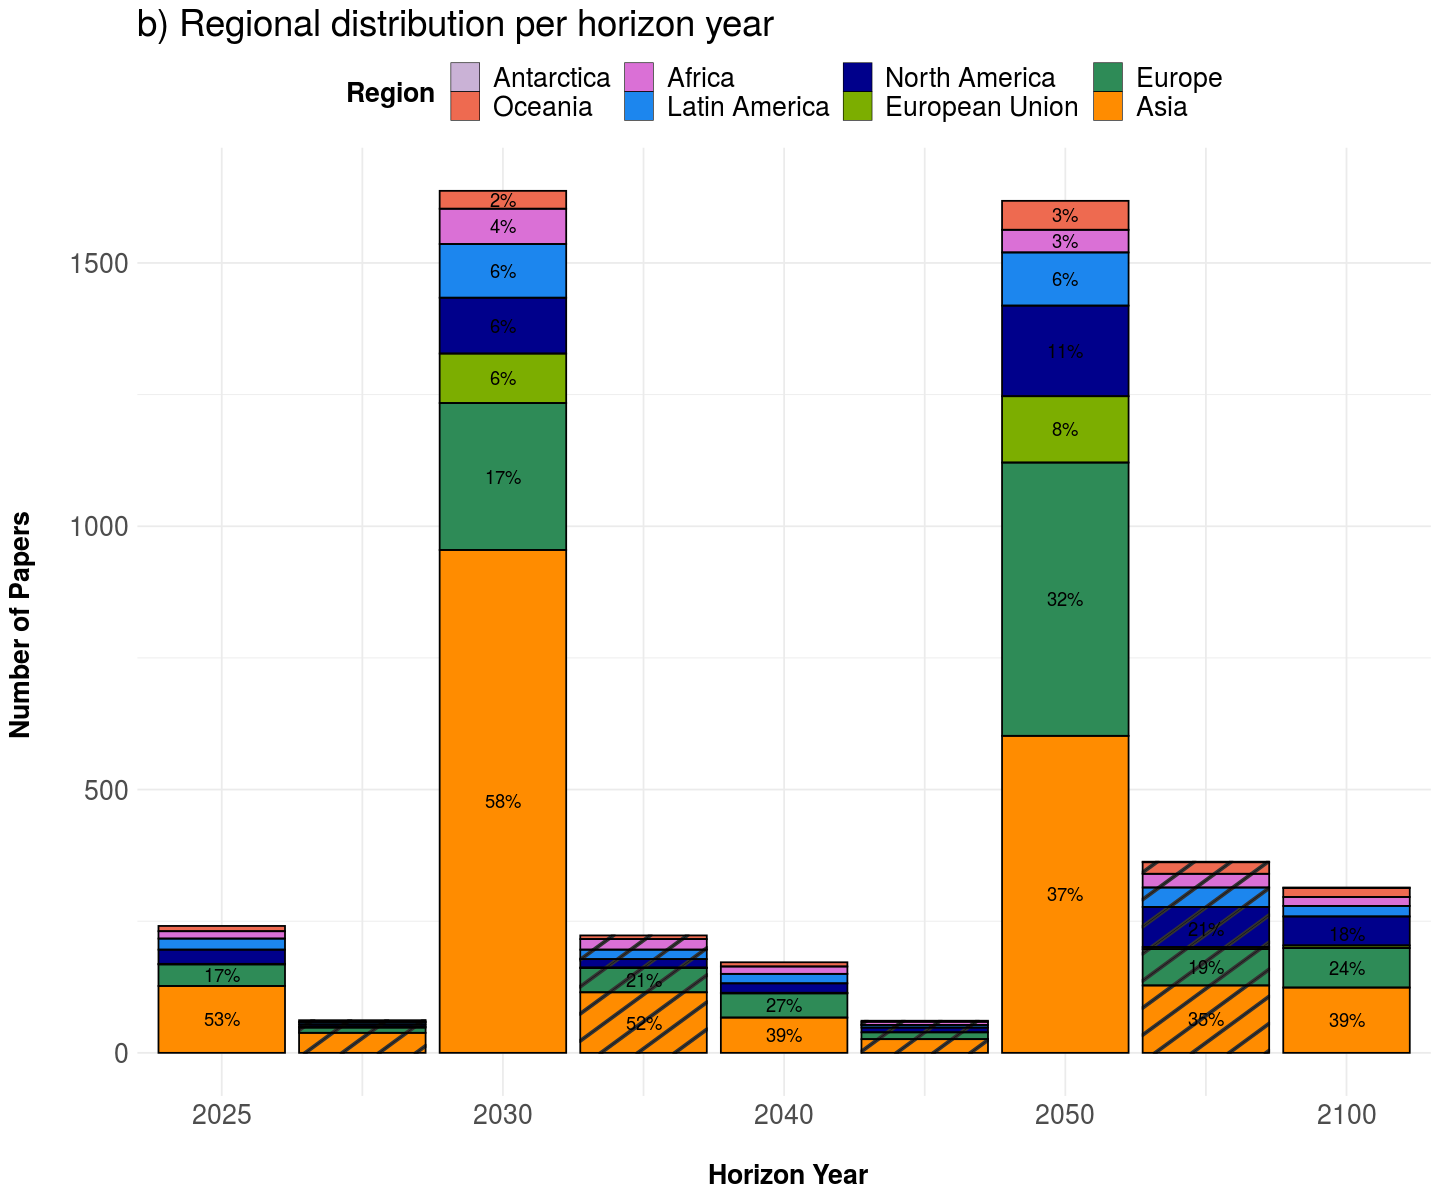

In [6]:
options(repr.plot.width=12, repr.plot.height=10)

plot_hor <- ggplot(data = df_hor, aes(x=hor_year,y=number,fill=Region, pattern = Estimated)) + 
          ggtitle('b) Regional distribution per horizon year')+ 
          geom_bar_pattern(stat="identity",
                           color = "black", 
                           pattern_fill = "black",
                           pattern_angle = 45,
                           pattern_density = 0.1,
                           pattern_spacing = 0.02,
                           pattern_key_scale_factor = 0.2) +
          scale_pattern_manual(values = c(aggregated = "stripe", yearly = "none")) +
          labs(x = " \n Horizon Year", y = "Number of Papers \n ", fill = "Region", pattern = "Level") + 
          guides(pattern = FALSE, fill = guide_legend(override.aes = list(pattern = "none")))+
          scale_x_discrete(labels = c("2025","","2030","","2040","","2050","","2100")) +
          scale_fill_manual(values=c('Asia'='darkorange',
                                   'European Union'='#7CAE00',
                                   'Europe'='seagreen4',
                                   'North America'='darkblue',
                                   'Latin America'='dodgerblue2',
                                   'Africa'='orchid',
                                   'Oceania'='coral2', 
                                   'Antarctica'='#CAB2D6')) + 
          geom_text(data = subset(df_hor,hor_year != 2030 & hor_year !=2050 & hor_year !=2027 & hor_year !=2045 & 
                                  relative >=15),
                    aes(x = hor_year, label = paste0(relative,'%')),
                    colour = 'black', position=position_stack(vjust=0.5))+
          geom_text(data = subset(df_hor,hor_year == 2030 | hor_year ==2050),
                    aes(x = hor_year, label = paste0(relative,'%')),
                    colour = 'black', position=position_stack(vjust=0.5))+
          theme_minimal()+
          theme(
            plot.title = element_text(size = rel(2)),
            legend.title = element_text(size = 16,face ="bold"),
            legend.text = element_text(size = 16),
            legend.position = 'top',
            axis.text.x = element_text(size = 16),
            axis.text.y = element_text(size = 16),
            axis.title.x = element_text(size = 16, hjust = 0.5,face ="bold"),
            axis.title.y = element_text(size = 16, hjust = 0.5,face ="bold")
          ) 
plot_hor

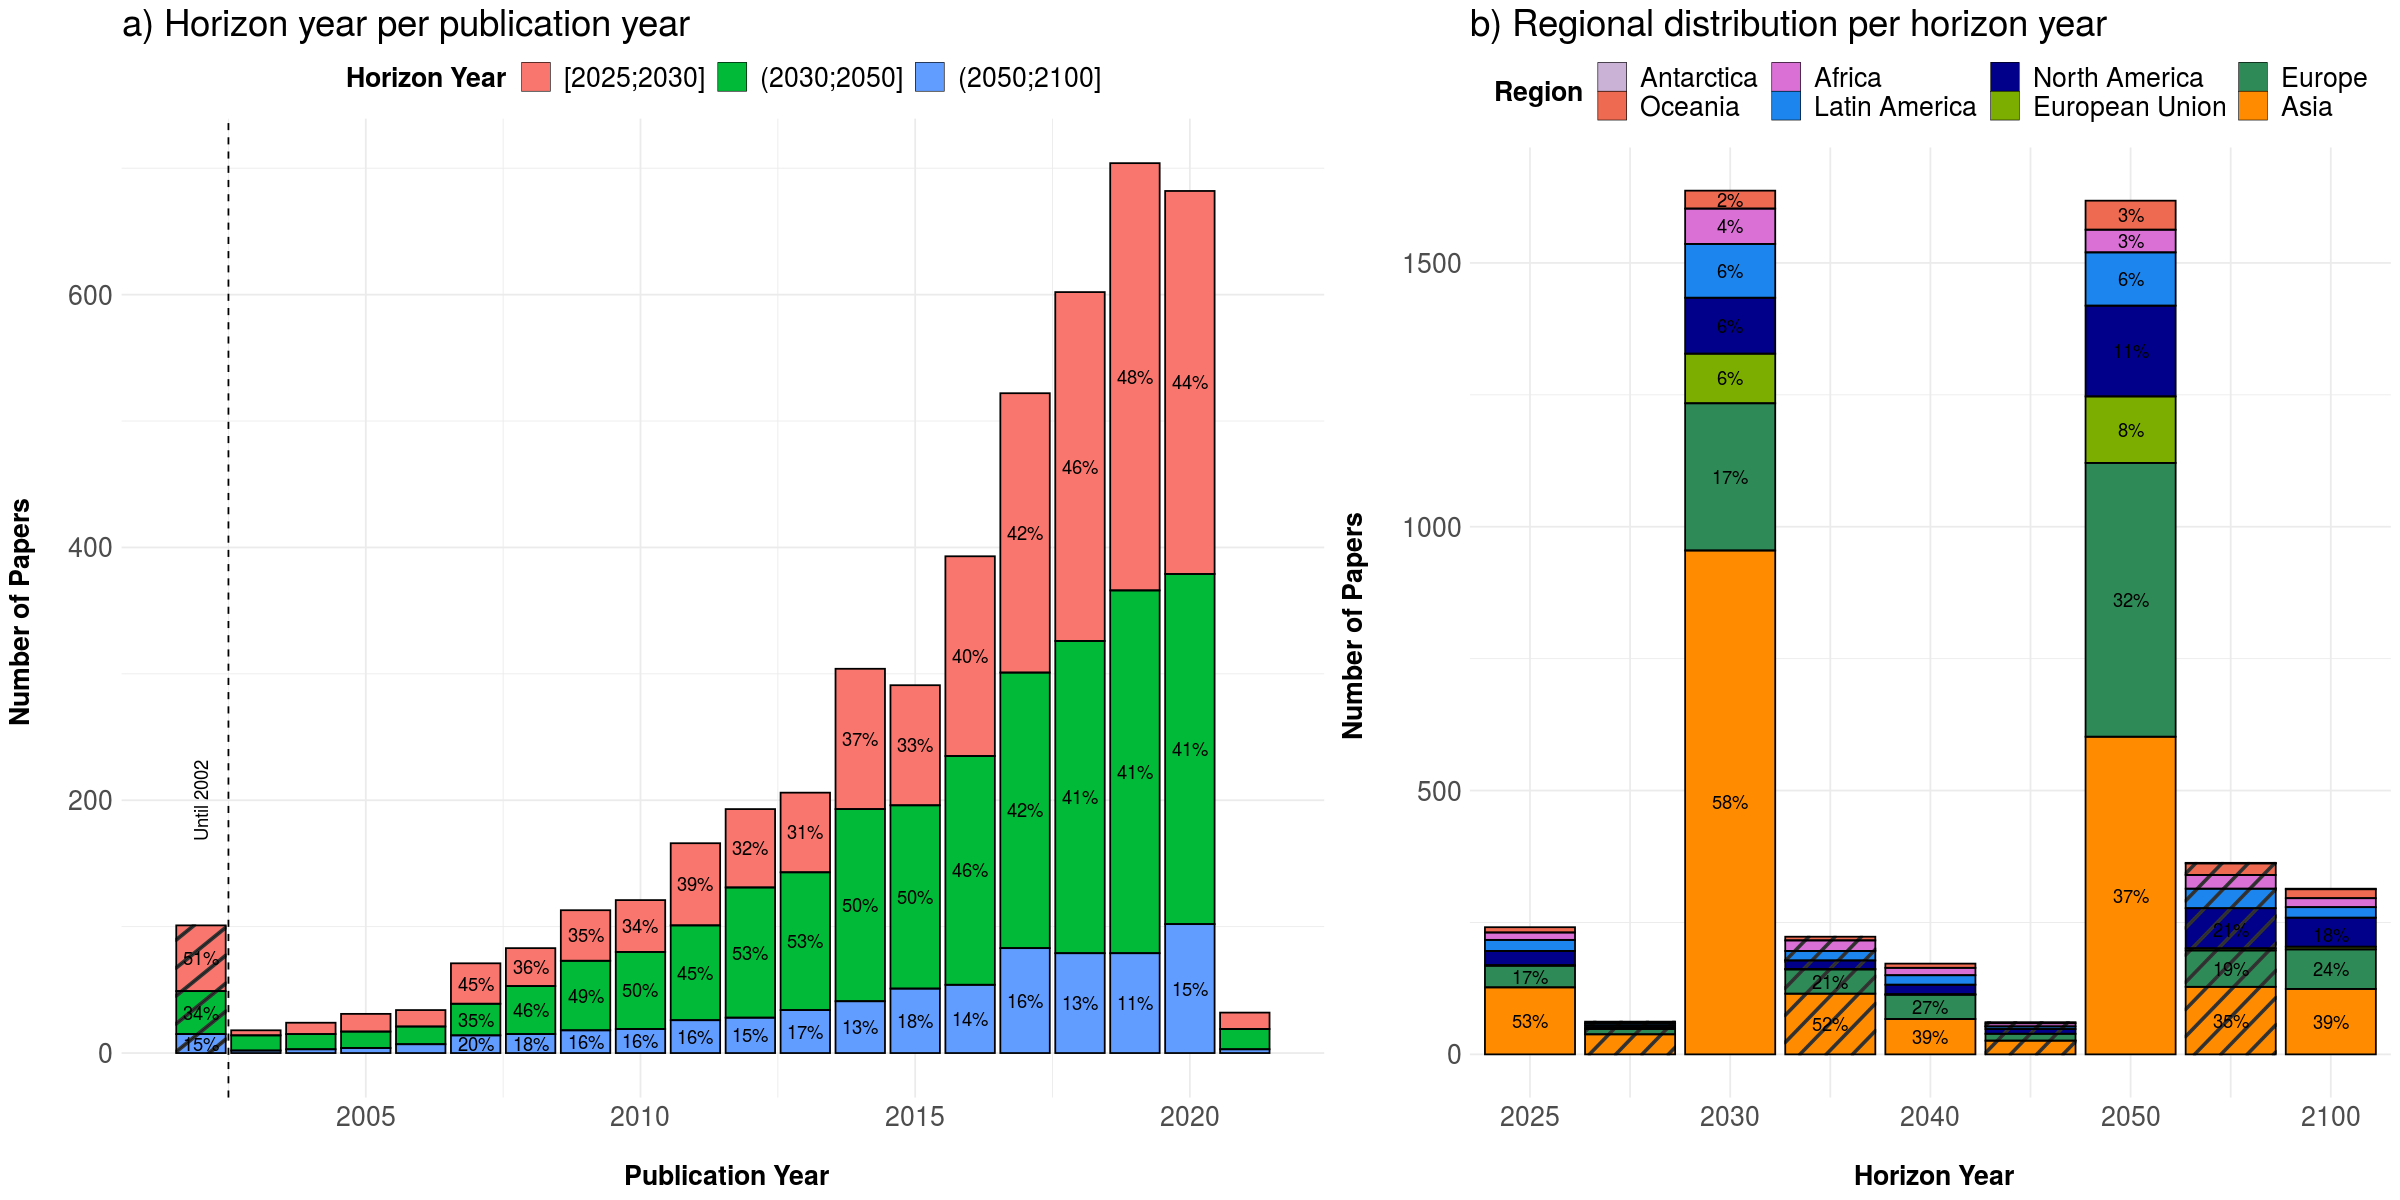

In [7]:
options(repr.plot.width=20, repr.plot.height=10)

plot <- ggarrange(plot_pub, plot_hor,
                  widths = c(5,4),
                 #common.legend = FALSE, 
                 #legend = "bottom",
                  ncol=2, nrow = 1
          )
plot

In [8]:
ggsave('./output/Fig3_distribution_years.png', height=10, width=20, plot=plot)